In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

from Distant_SigMA.SigMA.SigMA import SigMA
from scipy.stats import norm
from math import ceil
from scipy.stats import gaussian_kde
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.optimize import curve_fit

# Generate mock data

In [22]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [23]:
# Create 6D Gaussian data
np.random.seed(42) 
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 # correlation of x and y, positive -> there is a correlation 
c_zz = 3 #Variance in z 
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([10, -10, -10, -10, 10, -10])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-7, -7, -7, -7, -7, -7])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([2, -2, -2, 2, 2, 2])
c_xx_5 = c_yy_5 = 35
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

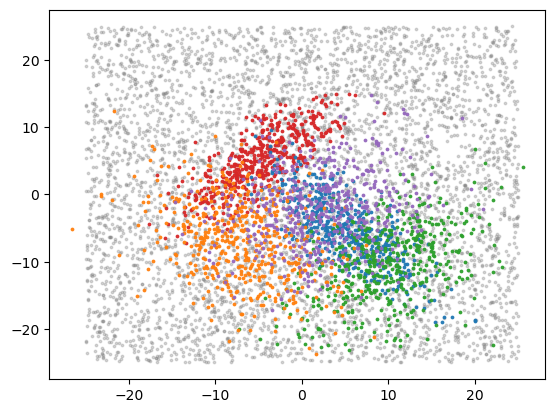

In [24]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

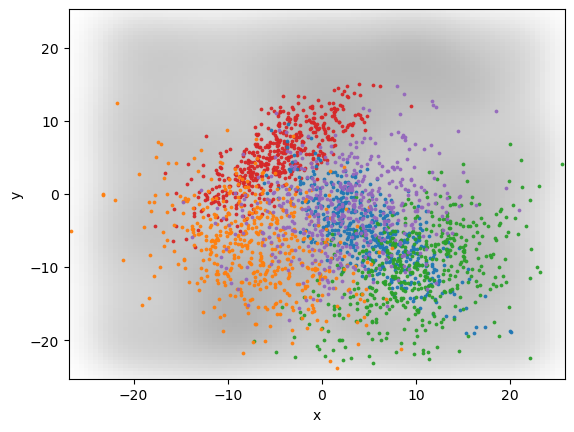

In [25]:
# Select background data (label 0)
X_bg_kde = df.loc[idx_bg, [x_col, y_col]].values.T

# Fit a Gaussian KDE to the background data
kde = gaussian_kde(X_bg_kde)

# Define a grid for plotting the KDE
x_min, x_max = df[x_col].min(), df[x_col].max()
y_min, y_max = df[y_col].min(), df[y_col].max()
X_grid, Y_grid = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

# Evaluate the KDE on the grid
Z_grid = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)

#make background sparse
plt.pcolormesh(X_grid, Y_grid, Z_grid, shading='auto', cmap='Greys', alpha=0.3)

for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
#plt.xlim(-25000, 25000)
#plt.ylim(-25000, 25000)
plt.xlabel(x_col)#x_col,r'$v_\alpha$ ($km$ $s^{-1}$)'
plt.ylabel(y_col)#y_col,r'$v_\delta$ ($km$ $s^{-1}$)'
plt.show()


In [26]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     -6.272994  22.535715  11.599697   4.932924 -17.199068 -17.200274   
1    -22.095819  18.308807   5.055751  10.403629 -23.970775  23.495493   
2     16.622132 -14.383044 -15.908752 -15.829775  -9.787888   1.237822   
3     -3.402749 -10.438543   5.592645 -18.025307 -10.392768  -6.681908   
4     -2.196501  14.258798 -15.016311   0.711722   4.620728 -22.677479   
...         ...        ...        ...        ...        ...        ...   
7495  -8.041993 -11.692424  -2.232863   2.876024   1.864116   3.552278   
7496  -2.285227   0.482529  -0.223022   0.326091   0.155987   1.596888   
7497  10.868562   6.198407  -7.762732   2.856226   2.133767   1.840010   
7498  -3.652450  -1.024975  -0.986144   1.148356   1.894017   1.676458   
7499   6.763112  -8.878300   0.611243   2.321478   2.153845   1.043406   

              ra        dec       dist        pmra       pmdec  \
0     281.680238  74.477071  26.110571   59.7

# Apply initial clustering of SigMa 

In [27]:
knn_list=[15, 20, 25, 30]
cluster_features = ['x', 'y','z'] #In which variables you want to cluster
sigma_kwargs = dict(
        cluster_features=cluster_features,
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

In [28]:
#make SigMA object
clusterer = SigMA(
            data=df,
            scale_factors=None, #needed for clustering in different spaces with scaling differences
            **sigma_kwargs
        )

In [29]:
#DO THE INITIAL CLUSTERS WITHOUT THE MERGING STEP OF RUN_SIGMA FUNCTION
clusterer.initialize_clustering(knn=20) #initialen cluster erstellt
clusterer.initialize_mode_neighbor_dict() #diese funktionen und mergeclusterer in parameters.py beschrieben
clusterer.resample_k_distances()# Compute k-distances for re-sampled data sets
leaf_labels = clusterer.leaf_labels_ 

Performing gradient ascend using a 20-NN density estimation.


In [30]:
np.unique(leaf_labels, return_counts = True) #the unique labels and how many in each leaf 

(array([  33,   73,  114,  169,  189,  238,  311,  404,  413,  427,  474,
         541,  660,  690,  691,  748,  754,  780,  855,  864,  874,  994,
         999, 1028, 1034, 1041, 1102, 1138, 1145, 1202, 1254, 1286, 1325,
        1392, 1414, 1549, 1557, 1611, 1735, 1773, 1855, 1870, 1911, 1943,
        2009, 2036, 2108, 2126, 2130, 2187, 2213, 2232, 2362, 2400, 2556,
        2564, 2567, 2593, 2620, 2678, 2712, 2958, 3034, 3107, 3170, 3248,
        3261, 3377, 3435, 3455, 3527, 3551, 3602, 3613, 3711, 3776, 3890,
        3904, 3999, 4078, 4209, 4307, 4324, 4387, 4440, 4442, 4500, 4553,
        4564, 4599, 4627, 4636, 4748, 4812, 4850, 4911, 4988, 5010, 5203,
        5247, 5404, 5485, 5588, 5623, 5664, 5681, 5701, 5721, 5723, 5735,
        5769, 5808, 5857, 5964, 6061, 6193, 6257, 6322, 6358, 6473, 6527,
        6661, 6691, 6694, 6726, 6731, 6768, 6817, 6913, 7039, 7060, 7229,
        7326, 7352, 7404, 7409], dtype=int64),
 array([ 67,  19,  10,  24,  69,  15,  29,  62,  32,  37,  16,  1

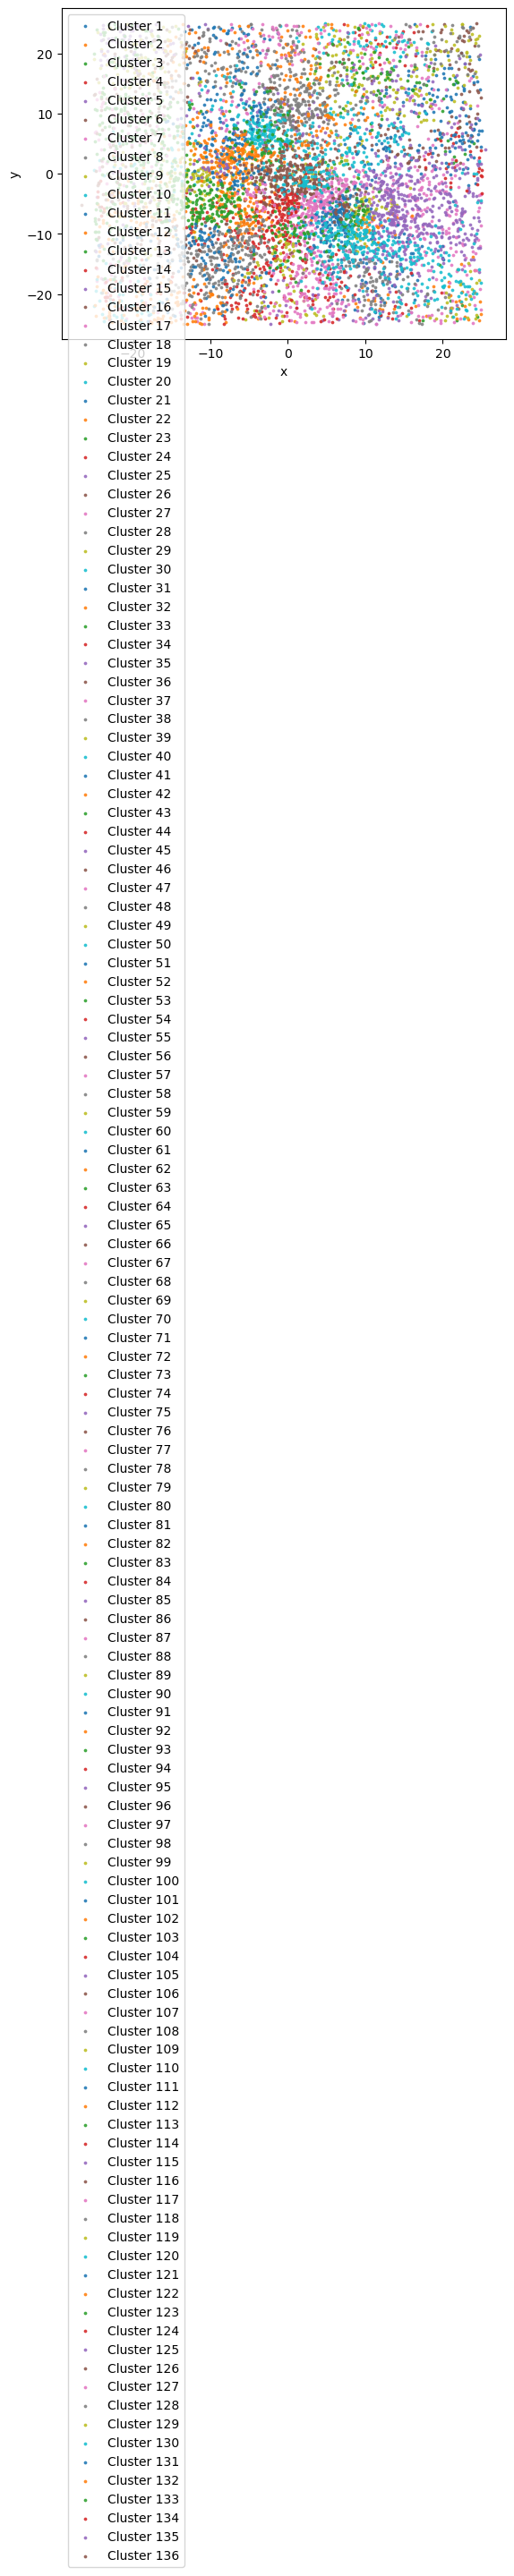

In [31]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'

for i, label in enumerate(np.unique(leaf_labels)):
    cluster_idx = np.where(leaf_labels == label)[0]  # Get the indices of the current cluster
    plt.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col], 
                s=3, label=f'Cluster {i+1}', alpha=0.8)

# Add plot labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

# Create initial fine partition:  
Explore hierachy, look into the parameters class (merge_clusters). 
Use run_sigma with -infinity, get pvalues and sort them by icreasing size. 
run mergeclusters fct over and over again using different pvalues (np array distribution btw 0 and 1 zoom in o close to 0 and you get individual values. Choose alpha to be btw the pvalues. whats the center. 
vizualize what it looks like as fct of the alpha value.

In [32]:
#RUN SIGMA WITH P-VALUES
labels_s, pvalues = clusterer.run_sigma(alpha=-np.infty,knn=20,return_pvalues= True) 
sorted_pvalues = sorted(pvalues)

Text(0, 0.5, 'Density')

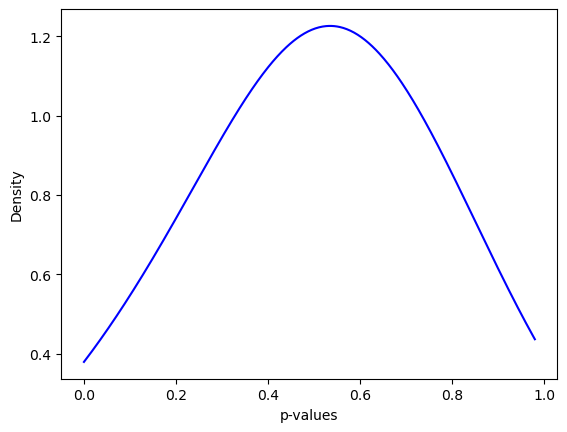

In [33]:
#PLOT DISTRIBUTION OF P-VALUES
mu = np.mean(sorted_pvalues)     
sigma = np.std(sorted_pvalues)    

# Compute the KDE
kde = gaussian_kde(sorted_pvalues, bw_method=1)

x_values = np.linspace(min(sorted_pvalues), max(sorted_pvalues), 500)
density = kde(x_values)

# Plot the normal distribution curve
plt.plot(x_values, density, color='blue')

plt.xlabel('p-values')
plt.ylabel('Density')

In [34]:
# zoom in in the region close to 0
###Ein kleinerer p-Wert bedeutet, dass die beobachteten Daten sehr unwahrscheinlich wären, wenn die Nullhypothese zutrifft###
lower_pvalues = [x for x in sorted_pvalues if x <= 0.2]
#make a list of alpha values that are the centers between all these pvalues
alpha_values = [(lower_pvalues[i] + lower_pvalues[i+1]) / 2 for i in range(len(lower_pvalues) - 1)]
print(lower_pvalues)
print(alpha_values) #Signifikanzniveau

[4.440892098500626e-16, 0.009575623018154955, 0.016700930074704634, 0.046971150771382586, 0.04896070848933731, 0.05035424729395421, 0.051768360269643265, 0.062333161847616614, 0.07802100322433103, 0.08547023048296398, 0.08921591718184563, 0.10147914717421291, 0.11120014357725383, 0.11391455598253164, 0.13563478379545224, 0.14192958097087294, 0.15755075685112352, 0.1581277982660756, 0.16761245715520157]
[0.0047878115090777, 0.013138276546429795, 0.03183604042304361, 0.04796592963035995, 0.04965747789164576, 0.05106130378179874, 0.05705076105862994, 0.07017708253597382, 0.08174561685364751, 0.0873430738324048, 0.09534753217802927, 0.10633964537573337, 0.11255734977989273, 0.12477466988899194, 0.1387821823831626, 0.14974016891099823, 0.15783927755859956, 0.16287012771063858]


[5485 5735]
[4636 5485 5735]
[3776 4636 5485 5735]
[3776 4636 5485 5701 5735]
[3776 4636 5485 5701 5735 6817]
[ 404 3776 4636 5485 5701 5735 6817]
[ 404 3776 4636 5010 5485 5701 5735 6817]
[ 404  754 3776 4636 5010 5485 5701 5735 6817]
[  33  404  754 3776 4636 5010 5485 5701 5735 6817]
[  33  404  754 3776 4636 5010 5485 5701 5735 6691 6817]
[  33  404  754 3435 3776 4636 5010 5485 5701 5735 6691 6817]
[  33  404  427  754 3435 3776 4636 5010 5485 5701 5735 6691 6817]
[  33  404  427  754 3435 3776 4440 4636 5010 5485 5701 5735 6691 6817]
[  33  404  427  754 3435 3776 4440 4636 5010 5203 5485 5701 5735 6691
 6817]
[  33  404  427  754 2362 3435 3776 4440 4636 5010 5203 5485 5701 5735
 6691 6817]
[  33  404  427  754 2362 3435 3776 4440 4636 5010 5203 5247 5485 5701
 5735 6691 6817]
[  33  404  427  754 2036 2362 3435 3776 4440 4636 5010 5203 5247 5485
 5701 5735 6691 6817]
[  33  404  427  754  864 2036 2362 3435 3776 4440 4636 5010 5203 5247
 5485 5701 5735 6691 6817]


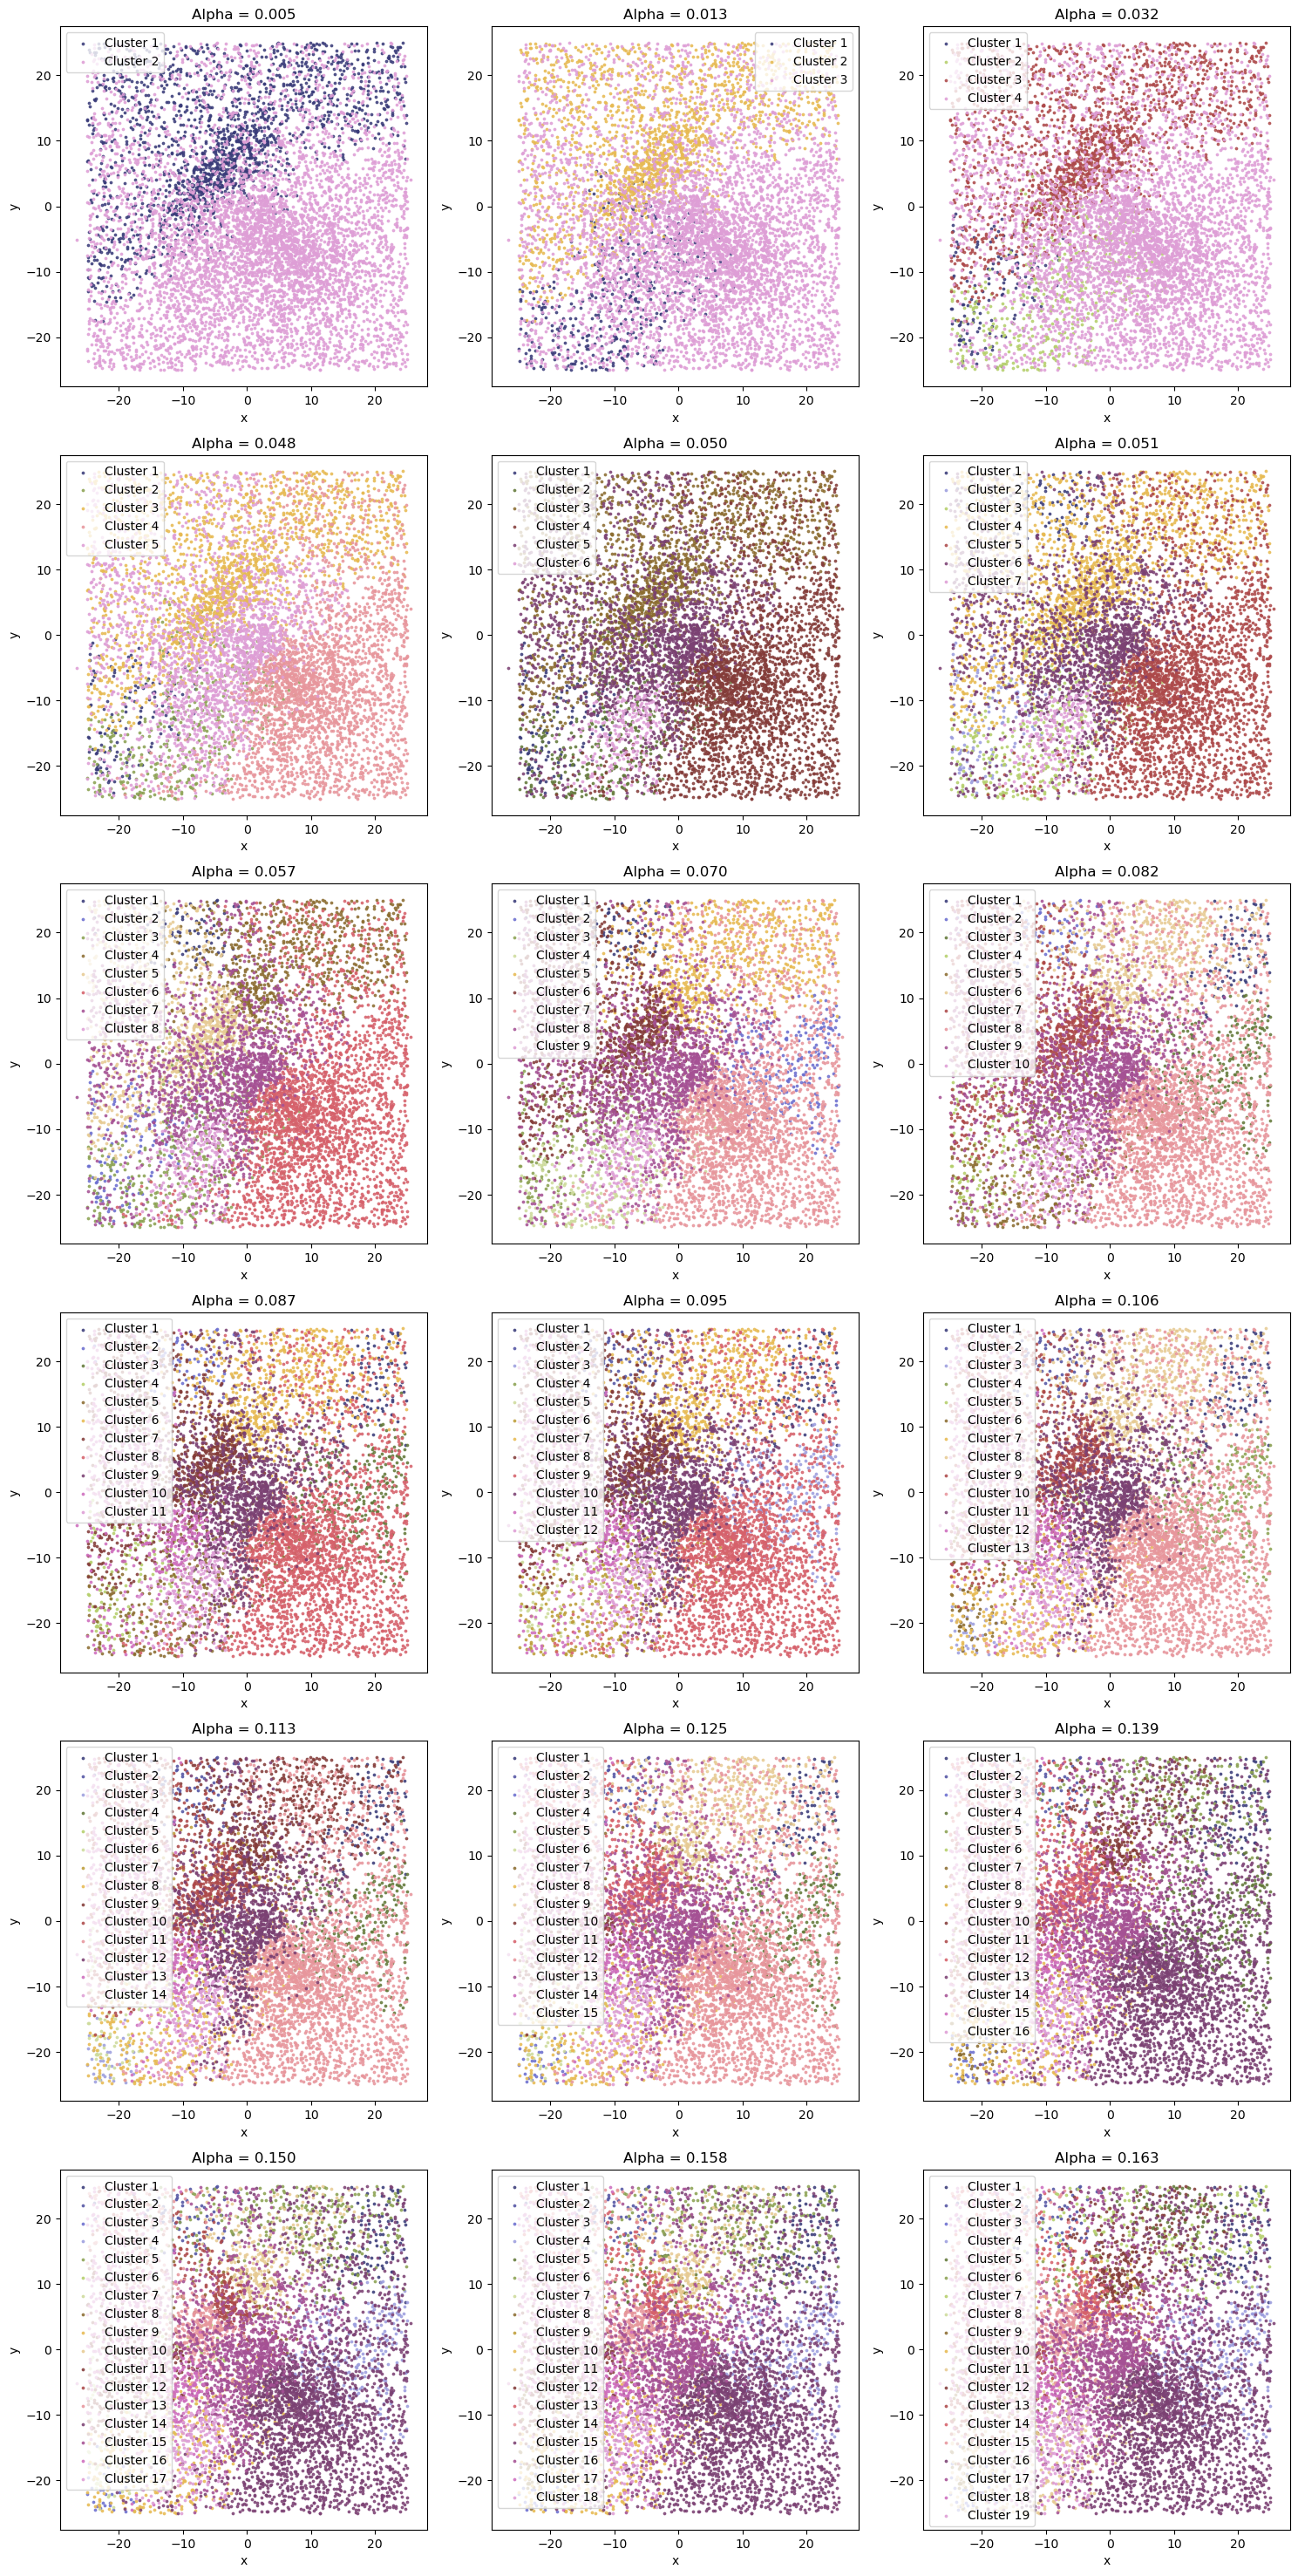

In [35]:
# dictionary to store results of merge_clusters for each alpha
merged_results = {}

# Run merge clustering for each alpha and store results
for alpha in alpha_values:
    merged_labels, merged_pvalues = clusterer.merge_clusters(knn=20, alpha=alpha)
    merged_results[alpha] = {
        "labels": merged_labels,
        "pvalues": merged_pvalues
    }

n_alpha = len(alpha_values)
cols = 3
rows = ceil(n_alpha / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    print(unique_labels)

    cmap = plt.get_cmap('tab20b', len(unique_labels))
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# How are real labels represented in unique labels  


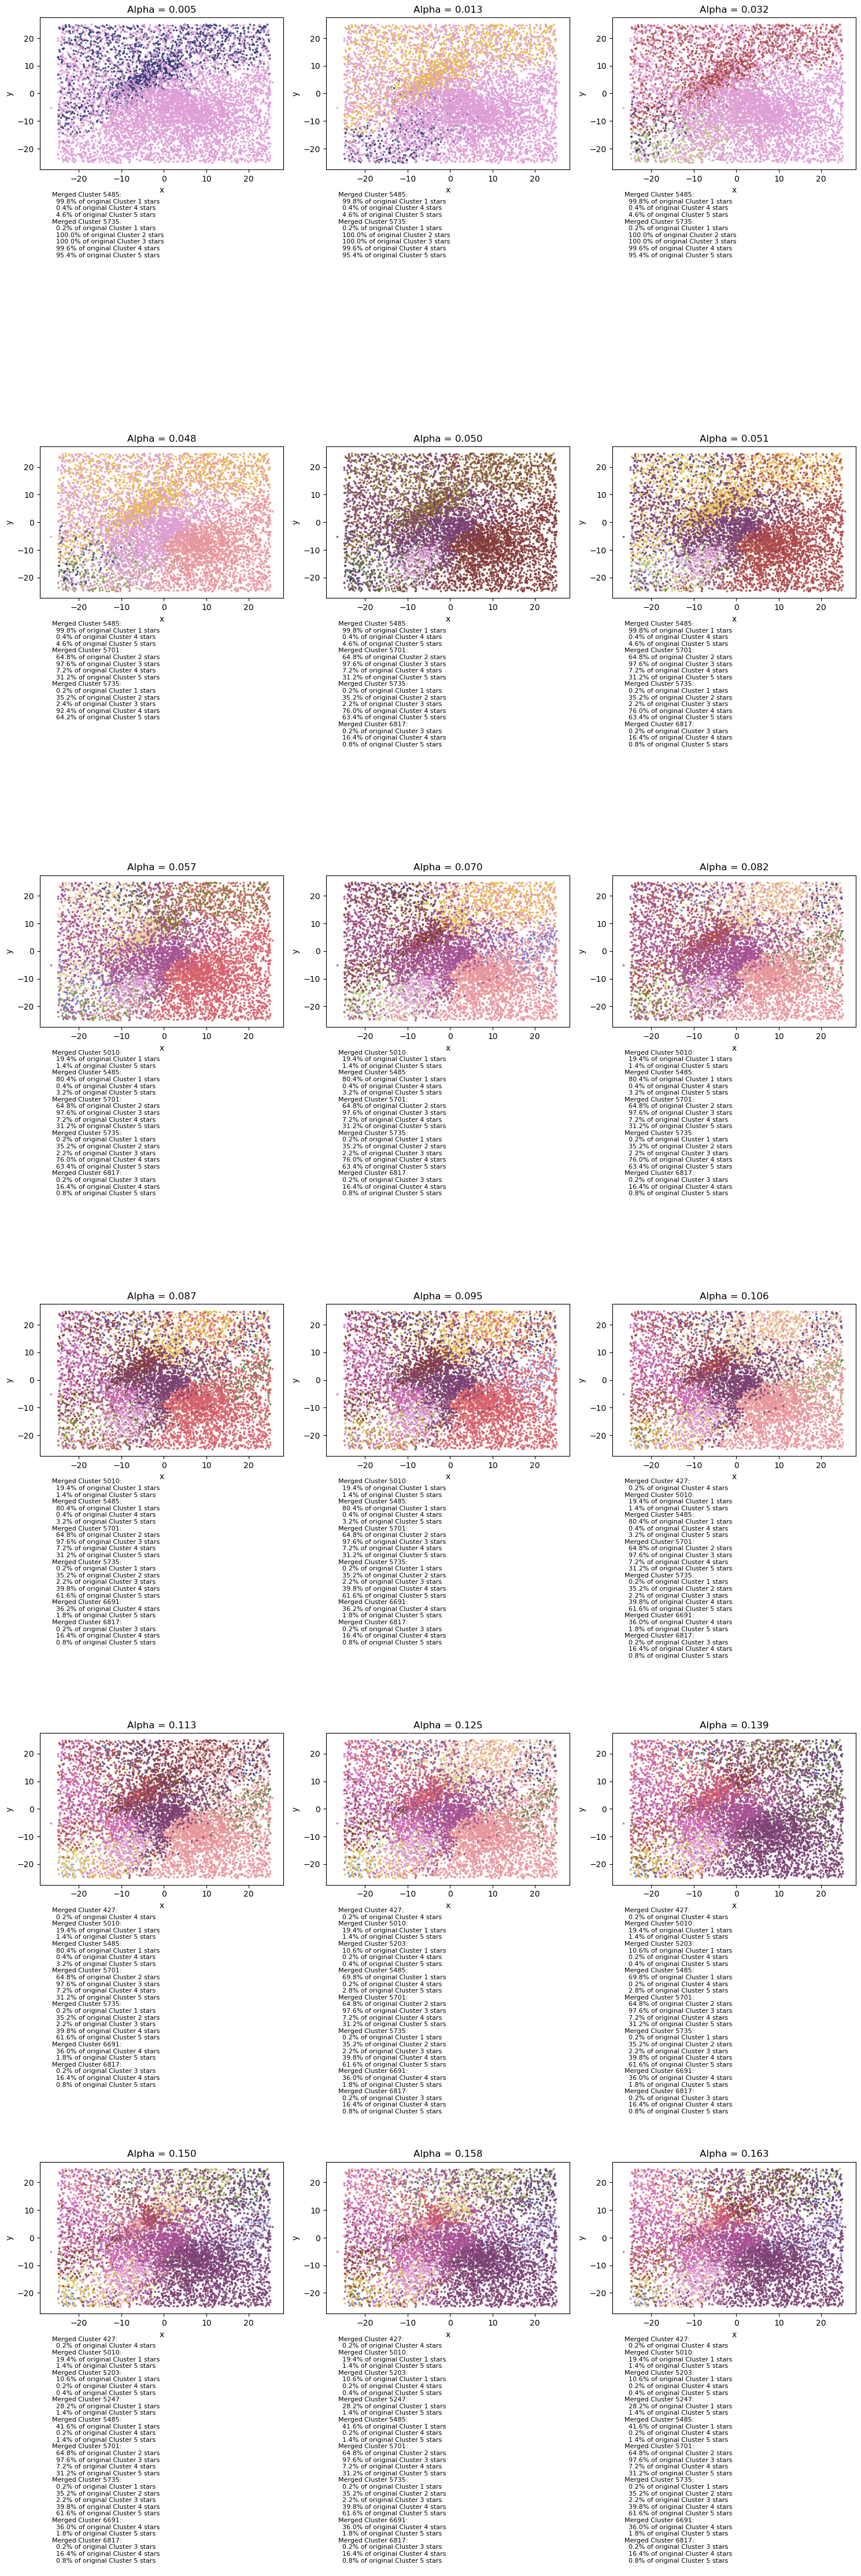

In [36]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 7.5 * rows))
axs = axs.flatten()

# original clusters as dictionary
original_clusters = {
    1: idx_cluster_1,
    2: idx_cluster_2,
    3: idx_cluster_3,
    4: idx_cluster_4,
    5: idx_cluster_5
}

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    cmap = plt.get_cmap('tab20b', len(unique_labels))

    # Initialize dictionary to store cluster distribution for display
    cluster_distribution = {}
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

        # Calculate distribution of original clusters within this merged cluster
        cluster_distribution[label] = {}
        for original_label, original_indices in original_clusters.items():
            common_indices = np.intersect1d(cluster_idx, original_indices)
            percentage = len(common_indices) / len(original_indices) * 100 if len(original_indices) > 0 else 0
            if percentage > 0:
                cluster_distribution[label][original_label] = percentage

    merge_info = ""
    for merged_label, distribution in cluster_distribution.items():
        if distribution:  # Only add if there's a non-zero percentage from any original clusters
            merge_info += f"Merged Cluster {merged_label}:\n"
            for original_label, percentage in distribution.items():
                merge_info += f"  {percentage:.1f}% of original Cluster {original_label} stars\n"

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.text(0.05, -0.15, merge_info, transform=ax.transAxes, fontsize=8, verticalalignment='top', wrap=True)

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# NMI plot (normalized_mutual_info_score)

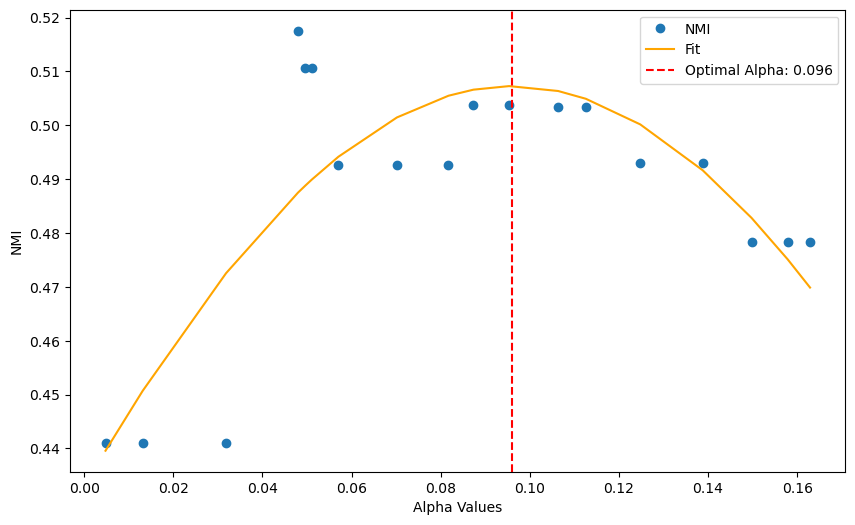

Optimal Alpha from fit: 0.096


In [40]:
#nmi sklearn für jedes splitting (alle labels die nicht 0 sind bei lab_t)
#nmi plot all merged to all split -> alpha ausrechnen - kann auch alpha auf x (nicht equidistant) -> berechne opt alpha 

labels_true = labels

# Gaussian fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculate NMI for each alpha value
nmi_scores = []
for alpha in alpha_values:
    labels_pred = merged_results[alpha]["labels"]
    filtered_true_labels = labels_true[labels_true != 0]
    filtered_pred_labels = labels_pred[labels_true != 0]

    nmi = normalized_mutual_info_score(filtered_true_labels, filtered_pred_labels)
    nmi_scores.append(nmi)

# Fit using Gaussian function
alpha_array = np.array(alpha_values[:len(nmi_scores)])
nmi_scores = np.array(nmi_scores)

popt, _ = curve_fit(gaussian, alpha_array, nmi_scores, p0=[1, np.mean(alpha_array), np.std(alpha_array)])

# determine optimal alpha
a, optimal_alpha, sigma = popt

# Plotting NMI against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alpha_array, nmi_scores, 'o', label='NMI')
plt.plot(alpha_array, gaussian(alpha_array, *popt), '-', label='Fit', color='orange')
plt.xlabel('Alpha Values')
plt.ylabel('NMI')
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f'Optimal Alpha: {optimal_alpha:.3f}')
plt.legend()
plt.show()

# Output the optimal alpha from fitted curve
print(f'Optimal Alpha from fit: {optimal_alpha:.3f}')

In [38]:
print(nmi_scores)

[0.44092533 0.44092533 0.44092533 0.51755538 0.51071763 0.51071763
 0.49260603 0.49260603 0.49260603 0.50379456 0.50379456 0.50339849
 0.50339849 0.49303721 0.49303721 0.47827458 0.47827458 0.47827458]


# Implement Softmax algorithm

In [39]:
#branch luisa - softmax optimized - lass auf deinem datenset laufen, berechne G (est Vropt) -> berechne dist Vopt 
# -> bau triag matrix mit indices len(X) -> nxn matrix mit opt distances 
# pi opt ist clustering ergebnis 
# K=6 (sie hat 6 cluster )  KxN matrix
#get clusters fct. entfernt spalten mit nur 0 
#plot ergebnis wie bei ihr in 36 
#ursprl. 5 cluster werden getrennt plus 6. cluster mit nur noise 
#B) lass nich auf ganzes laufen aber auf die sets wie hier  - berechne G bei zb in 2 gesplitteten G1 G2 (man muss mit ind spielen)
# lass softmax wieder laufen - wie gut clustering ergebnis ? nmi ?
#labels_softmax_opt für G1 und G2 -> merge cluster result von G1 G2 
#pass auf mit indizes 01 eg 012 -> 234
#nmi - wie ist kurve - wird es besser - trenn mehr auf (komplett seperate zellen betrachten aber evt. 1 cluster komm in mehreeren zellen vor)
#annahme nmi nimmt ab

#iphd 